##  This notebook uses transfer Learning from the resnet18 architecture to predict the classes of COVID19, Normal and Pneumonia diagnosed Chest X Ray images. It also looks into how tweaking the layers trained by adding or reducng the number of trainable layers affects the model performance. 

### The dataset can e found at https://www.kaggle.com/datasets/prashant268/chest-xray-covid19-pneumonia/data

In [49]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torchvision
from pathlib import Path
import PIL
from PIL import Image
from torchvision import transforms
import pandas as pd
import cv2
from tqdm.notebook import tqdm
import torchmetrics
import seaborn as sns
import json

### Analyzing the dataset below shows the counts per class, It can be seen that the number of examples for COVID19 is much less than that for normal and Pneumonia. A weighted Random Sampler will be used to tackl this issue at a later stage in the notebook.

In [2]:
root_path = Path('Data/train')
labels = []
for folders in root_path.glob('*'):
    for label in folders.glob('*'):
        labels.append(folders.parts[-1])
print(np.unique(np.array(labels), return_counts=True))

(array(['COVID19', 'NORMAL', 'PNEUMONIA'], dtype='<U9'), array([ 460, 1266, 3418], dtype=int64))


###  Looking at the descriptive stats of some of the images the COVID19 subfolder(you can choose to see all) it can be seen that the dimensions vary vastly and even the channel dimensions are composed of 3 and 4 colour channels.

In [3]:
train_path = Path('Data/train/COVID19/')
size_list = []
size_list = [np.asarray(Image.open(i)).shape for i in list(train_path.glob('*'))]
df = pd.DataFrame(size_list,columns = ['H', 'W', 'C'] )
df.describe()

,H,W,C
count,460.000000,460.000000,336.000000
mean,1309.558696,1439.773913,3.107143
std,710.897474,805.120157,0.309756
min,224.000000,224.000000,3.000000
25%,744.500000,886.500000,3.000000
50%,1024.000000,1050.500000,3.000000
75%,1971.000000,2000.000000,3.000000
max,4757.000000,5623.000000,4.000000


### The helper function below is used later to convert the images to grayscale and resize the image to 224 x 224 pixels.


In [6]:
def load(path):
    img = Image.open(path)
    img = PIL.ImageOps.grayscale(img) 
    img = cv2.resize(np.asarray(img), (224,224)).astype(np.float32)/255
    return img
    
#Check that the helper function works as expected
size_list = [load(i).shape for i in list(train_path.glob('*'))]
df = pd.DataFrame(size_list)
df.describe()

,0,1
count,460.0,460.0
mean,224.0,224.0
std,0.0,0.0
min,224.0,224.0
25%,224.0,224.0
50%,224.0,224.0
75%,224.0,224.0
max,224.0,224.0


### Preprocessing consists of normalizing the images using mean and standard deviation in the training set. Further processsing involves Random Affine, Rotaions, HorizontalFLips, ResizedCrops and Elastic Tranformation for the training dataset and Normalization for the validation dataset.

In [8]:
def mean_std(root_path):
    sums, sum_squared = 0,0
    files = 0
    for path in tqdm(list(root_path.glob('*')), total = len(list(root_path.glob('*')))):
        for p in tqdm(list(path.glob('*'))):
            img = load(p)
            sums+= np.sum(img)/(img.shape[0]*img.shape[1])
            sum_squared+= np.sum(img**2)/(img.shape[0]*img.shape[1])
            files+=1
    print(files)
    mean = sums/files
    std = np.sqrt((sum_squared/files) - (mean**2))
    return mean, std
mean, std = mean_std(Path('Data/train'))
print(mean, std)

train_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean = mean, std =std), transforms.RandomAffine(degrees = (-5,5),
    translate=(0, 0.05),
    scale=(0.9, 1.1)), transforms.RandomRotation(10),transforms.RandomResizedCrop((224,224), #(0.9,1.1),
    scale=(0.35, 1)),
    transforms.RandomHorizontalFlip(p =0.3),
    transforms.ElasticTransform()])
val_transform =  transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean = mean, std =std)])

In [7]:
# mean, std = 0.4920391255128484, 0.23256543325130302

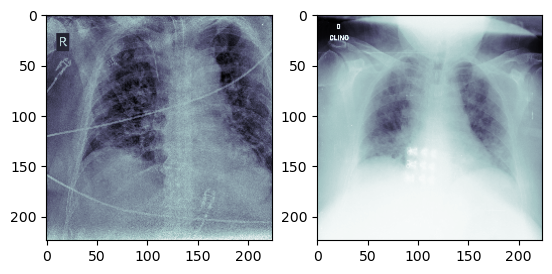

In [9]:
train_path = Path('Data/train/COVID19/')
fig, ax = plt.subplots(1,2)
n = 0
for i in list(train_path.glob('*')):
    im = load(i)
    ax[n].imshow(im, cmap = 'bone')
    n+=1
    if n==2:
        break

### A custom dataset that takes both the train and test folders and shuffles it, applies reatransformations. THis provided with better training results that using the train and test folders separately. Covid19, Normal and Pneumonia labels  mapped to classes 0 ,1 and 2 respectively.

In [10]:
class LungDataset(torch.utils.data.Dataset):
    '''
    Custom Dataset to shuffle and transform images in the main Data folder
    
    Arguments:    
    
    rootpath: The main path to folder named Data containing the subfolders
    
    train_tranforms: Tranformations for training data of class torchvision.transforms
    
    val_tranforms: Tranformations for validation data of class torchvision.transforms
    
    num_train: Number of training examples to produce. When making validation set num_train must be equal to num_train
    set for training data.
    
    seed_val: Random seed to produce the shuffle. Must be same for both training and validation dataset creation.
    '''
    def __init__(self, rootpath= None, train_transforms= None, val_transforms= None,num_train= None,seed_val= 42):
        super().__init__()
        self.train_transforms = train_transforms
        self.val_transforms = val_transforms
        self.num_train = num_train
        self.filenames = self.extractandshuffle(rootpath, seed_val)

    #Extract all the file paths
    def extractandshuffle(self, path, seed_val):
        files = []
        for paths in list(path.glob('*')):
            # print(paths)
            for classes in list(paths.glob('*')):
                # print(classes)
                for f in list(classes.glob('*')):
                    # print(f)
                    files.append((f, classes))
        #Shuffle the data and split based on train or validation dataset
        np.random.seed(seed_val)
        np.random.shuffle(files)
        if self.train_transforms!=None:
            files = files[:self.num_train]
        else:
            files = files[self.num_train:]
        return files

    #Convert labels to integers
    @staticmethod
    def get_label(path):
        labels =['COVID19', 'NORMAL', 'PNEUMONIA']
        return labels.index(list(path.parts)[-1])
        
    #Convert to greyascale and resize image to 224 x 224    
    def load(self, path, transforms):
        img = Image.open(path)
        img = PIL.ImageOps.grayscale(img) 
        img = cv2.resize(np.asarray(img), (224,224)).astype(np.float32)/255
        img = transforms(img)
        return img

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, index):
        file_id = self.filenames[index][0]
        label = self.filenames[index][1]
        if self.train_transforms !=None:  
            return self.load(file_id, self.train_transforms), self.get_label(label)
        else:
            return self.load(file_id, self.val_transforms), self.get_label(label)
                

In [11]:
root_path = Path('Data')
train_data = LungDataset(root_path, train_transform, None, 5144, 42)
val_data = LungDataset(root_path, None, val_transform, 5144, 42)

### Calculate class weights to be used in the Random Weighted Sampler

In [ ]:
classes = np.array([i[1] for i in train_data])
weights = np.unique(classes, return_counts=True)[1]
weights = len(classes)/weights
print(np.unique(classes, return_counts=True))
print(weights)
class_weights =[]
for _, label in tqdm(train_data):
    if label == 0:
        class_weights.append(weights[0])
    elif label == 1:
        class_weights.append(weights[1])
    elif label == 2:
        class_weights.append(weights[2])
    else:
        print('Unknown class')

In [12]:
np.save('class_weights_shuffled', class_weights) # Save in case of cars or to be used again in which case it can be loaded.
class_weights =np.load('class_weights_shuffled.npy')

In [13]:
sampler = torch.utils.data.WeightedRandomSampler(weights = class_weights, num_samples=len(train_data))
train_loader = torch.utils.data.DataLoader(dataset = train_data, sampler = sampler, batch_size=10)
val_loader = torch.utils.data.DataLoader(dataset = val_data, shuffle = False, batch_size=10)

In [14]:
len(train_loader), len(val_loader)

(515, 129)

### Check that the train_loader samples as expected

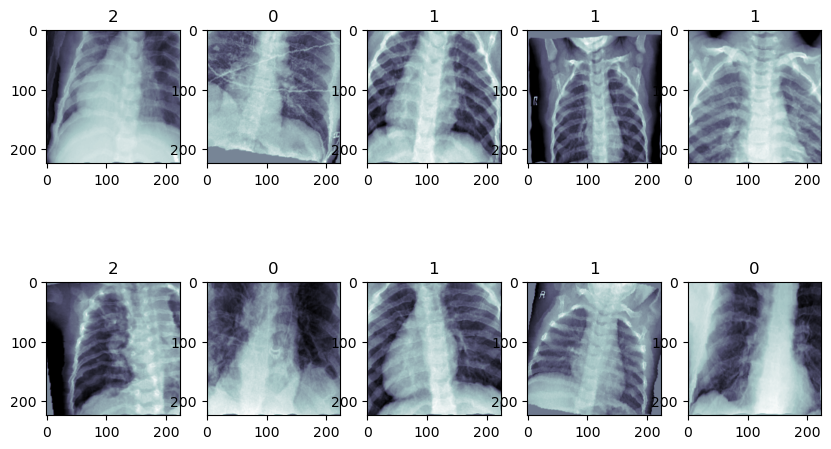

In [15]:
for b, (X,y) in enumerate(train_loader):
    fig, ax = plt.subplots(2,5, figsize =(10,6))
    k=0
    for i in range(2):
        for j in range(5):
            ax[i][j].imshow(np.transpose(X[k].numpy(), (1,2,0)), cmap = 'bone')
            ax[i][j].set_title(y[k].item())
            k+=1

    break

### The resnet18 is used to train the model. A pretrained model is selected. The first conv1 layer which has an input of 3 is changed to an input of 1 since the dataset has grayscale images. The last fully connected layer fc which has outputs 1000 featres is changed to 3 to predict 3 classes. Furthemore helper fuctions to select the layers based on their index to train them is written below and can be used to tweak the number of layers trained.

In [16]:
from torchvision.models import resnet18

In [17]:
model = resnet18(pretrained=True)
model

D:\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [18]:
class ResNet(torch.nn.Module):
    '''
    Class representing the resnet18 pretrained model.

    Arguments:
    in_channels: number of inout channels
    out_features: number of classes to predcit
    layers: list of indices of model layers where requires_grad is set to True to train..
    '''
    def __init__(self,in_channels, out_features, layers =None):
        super().__init__()
        torch.manual_seed(4)
        self.model = resnet18(pretrained=True)
        self.model.conv1 = torch.nn.Conv2d(in_channels, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.model.fc = torch.nn.Linear(in_features=512, out_features=out_features, bias=True)
        self.num_parameters = len(list(self.model.named_parameters()))
        if layers:
            for l in range(self.num_parameters):
                name,param =  list(self.model.named_parameters())[l]
                param.requires_grad = False
            
            for l in layers:           
                name,param =  list(self.model.named_parameters())[l]
                param.requires_grad = True
                print(f'Setting {name} grad to True') #To print the layers with gradients turned off

    def forward(self, X):
        pred = self.model(X)
        return pred

def optimizer_model_parameters(model, *layers):
    '''
    Return list of paramters for optimizer to optimize according to layers set in ResNet()

    Arguments:
    *layers: arguments of layer indices set to be trained in the ResNet() model
    '''
    param = []
    for i in layers:
        param.append(list(model.parameters())[i])
    return param        

### Model was trained to 50 epochs with the last 5 layers trained with Stochastic Gradient Descent andlearning rate intially set to 0.1 with learning rate decay.

In [25]:
new_model = ResNet(1,3, [0,-2,-1])
new_model;
device = ['cuda:0' if torch.cuda.is_available() == True else 'cpu']
    
epochs = 50
model_parameters = optimizer_model_parameters(new_model, 0,-2,-1)
optimizer = torch.optim.SGD(model_parameters,lr=0.1, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 10,gamma = 0.1)
train_losses=[]
val_losses = []
Train_Accuracy= []
Val_Accuracy = []

new_model = new_model.to(device[0])


Setting conv1.weight grad to True
Setting fc.weight grad to True
Setting fc.bias grad to True


In [17]:
#Check to make sure the gradients are set accordingly
for name,p in new_model.named_parameters():
    print(p.requires_grad)

True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True


In [18]:
for e in tqdm(range(epochs)):
    torch.manual_seed(e)
    train_batch_corr = 0
    print('**************************Training Results*********************************')
    for b, (X_train, y_train) in tqdm(enumerate(train_loader), total = len(train_loader)):
        
        pred = new_model(X_train.float().to(device[0]))
        loss= criterion(pred.cpu(), y_train)
        train_batch_corr+= torch.sum(torch.argmax(pred.cpu(), dim=1)==y_train).item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if b % 200 ==0:
            print(f'Epoch,batch: {e,b} Loss:{loss.item()} Accuracy: {train_batch_corr/((b+1)*len(y_train))}')
          
    lr_scheduler.step()
    train_losses.append(loss.item())
    Train_Accuracy.append(train_batch_corr/(len(train_data)))
    print(f'Epoch: {e}  Train Accuracy: {train_batch_corr/(len(train_data))}')
    
    
    print('**************************Validation Results*********************************')
    with torch.no_grad():        
        val_batch_corr = 0
        
        for b_t, (X_test, y_test) in tqdm(enumerate(val_loader), total = len(val_loader)):
            
            val_pred = new_model(X_test.float().to(device[0]))
            vloss= criterion(val_pred.cpu(), y_test)
            val_batch_corr+= torch.sum(torch.argmax(val_pred.cpu(), dim=1)==y_test).item()
            if b_t % 50 ==0:
                
                print(f'Epoch,batch: {e,b_t} Loss:{vloss.item()} Accuracy: {val_batch_corr/((b_t+1)*len(y_test))}')
        val_losses.append(vloss.item())           
        Val_Accuracy.append(val_batch_corr/(len(val_data)))
        print(f'Epoch: {e}  Val Accuracy: {val_batch_corr/(len(val_data))}')

  0%|          | 0/50 [00:00<?, ?it/s]

**************************Training Results*********************************


  0%|          | 0/515 [00:00<?, ?it/s]

D:\anaconda3\Lib\site-packages\torch\autograd\graph.py:768: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\cuda\CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch,batch: (0, 0) Loss:0.9578058123588562 Accuracy: 0.6
Epoch,batch: (0, 200) Loss:4.278578281402588 Accuracy: 0.6039800995024875
Epoch,batch: (0, 400) Loss:23.275142669677734 Accuracy: 0.6668329177057356
Epoch: 0  Train Accuracy: 0.6677682737169518
**************************Validation Results*********************************


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch,batch: (0, 0) Loss:58.82231903076172 Accuracy: 0.4
Epoch,batch: (0, 50) Loss:55.84563064575195 Accuracy: 0.46862745098039216
Epoch,batch: (0, 100) Loss:62.09025955200195 Accuracy: 0.42574257425742573
Epoch: 0  Val Accuracy: 0.43478260869565216
**************************Training Results*********************************


  0%|          | 0/515 [00:00<?, ?it/s]

Epoch,batch: (1, 0) Loss:4.249990463256836 Accuracy: 0.8
Epoch,batch: (1, 200) Loss:3.2102012634277344 Accuracy: 0.699502487562189
Epoch,batch: (1, 400) Loss:84.00042724609375 Accuracy: 0.6997506234413965
Epoch: 1  Train Accuracy: 0.6992612752721618
**************************Validation Results*********************************


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch,batch: (1, 0) Loss:7.726352691650391 Accuracy: 0.8
Epoch,batch: (1, 50) Loss:28.53937339782715 Accuracy: 0.5372549019607843
Epoch,batch: (1, 100) Loss:33.517547607421875 Accuracy: 0.5445544554455446
Epoch: 1  Val Accuracy: 0.5411490683229814
**************************Training Results*********************************


  0%|          | 0/515 [00:00<?, ?it/s]

Epoch,batch: (2, 0) Loss:49.00734329223633 Accuracy: 0.5
Epoch,batch: (2, 200) Loss:3.8299224376678467 Accuracy: 0.6950248756218905
Epoch,batch: (2, 400) Loss:0.0 Accuracy: 0.7069825436408977
Epoch: 2  Train Accuracy: 0.713841368584759
**************************Validation Results*********************************


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch,batch: (2, 0) Loss:15.623390197753906 Accuracy: 0.6
Epoch,batch: (2, 50) Loss:19.22736167907715 Accuracy: 0.707843137254902
Epoch,batch: (2, 100) Loss:22.96646499633789 Accuracy: 0.6732673267326733
Epoch: 2  Val Accuracy: 0.6731366459627329
**************************Training Results*********************************


  0%|          | 0/515 [00:00<?, ?it/s]

Epoch,batch: (3, 0) Loss:2.8878369331359863 Accuracy: 0.9
Epoch,batch: (3, 200) Loss:56.0836296081543 Accuracy: 0.7174129353233831
Epoch,batch: (3, 400) Loss:21.566730499267578 Accuracy: 0.7296758104738155
Epoch: 3  Train Accuracy: 0.7348367029548989
**************************Validation Results*********************************


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch,batch: (3, 0) Loss:8.604227066040039 Accuracy: 0.7
Epoch,batch: (3, 50) Loss:15.305567741394043 Accuracy: 0.7764705882352941
Epoch,batch: (3, 100) Loss:27.666656494140625 Accuracy: 0.7564356435643564
Epoch: 3  Val Accuracy: 0.7631987577639752
**************************Training Results*********************************


  0%|          | 0/515 [00:00<?, ?it/s]

Epoch,batch: (4, 0) Loss:7.2013258934021 Accuracy: 0.9
Epoch,batch: (4, 200) Loss:5.872136116027832 Accuracy: 0.745273631840796
Epoch,batch: (4, 400) Loss:4.591959476470947 Accuracy: 0.7518703241895262
Epoch: 4  Train Accuracy: 0.7595256609642301
**************************Validation Results*********************************


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch,batch: (4, 0) Loss:1.208713412284851 Accuracy: 0.9
Epoch,batch: (4, 50) Loss:0.7295924425125122 Accuracy: 0.8588235294117647
Epoch,batch: (4, 100) Loss:18.90467071533203 Accuracy: 0.8485148514851485
Epoch: 4  Val Accuracy: 0.859472049689441
**************************Training Results*********************************


  0%|          | 0/515 [00:00<?, ?it/s]

Epoch,batch: (5, 0) Loss:0.3759487569332123 Accuracy: 0.9
Epoch,batch: (5, 200) Loss:7.409619331359863 Accuracy: 0.7482587064676617
Epoch,batch: (5, 400) Loss:40.90281295776367 Accuracy: 0.7396508728179552
Epoch: 5  Train Accuracy: 0.745334370139969
**************************Validation Results*********************************


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch,batch: (5, 0) Loss:92.16622161865234 Accuracy: 0.3
Epoch,batch: (5, 50) Loss:96.99192810058594 Accuracy: 0.3803921568627451
Epoch,batch: (5, 100) Loss:101.97923278808594 Accuracy: 0.3455445544554455
Epoch: 5  Val Accuracy: 0.3501552795031056
**************************Training Results*********************************


  0%|          | 0/515 [00:00<?, ?it/s]

Epoch,batch: (6, 0) Loss:36.01941680908203 Accuracy: 0.6
Epoch,batch: (6, 200) Loss:11.768961906433105 Accuracy: 0.7865671641791044
Epoch,batch: (6, 400) Loss:7.599607944488525 Accuracy: 0.7890274314214464
Epoch: 6  Train Accuracy: 0.7799377916018663
**************************Validation Results*********************************


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch,batch: (6, 0) Loss:32.33950424194336 Accuracy: 0.5
Epoch,batch: (6, 50) Loss:33.592018127441406 Accuracy: 0.6196078431372549
Epoch,batch: (6, 100) Loss:41.00695037841797 Accuracy: 0.595049504950495
Epoch: 6  Val Accuracy: 0.6017080745341615
**************************Training Results*********************************


  0%|          | 0/515 [00:00<?, ?it/s]

Epoch,batch: (7, 0) Loss:15.628705978393555 Accuracy: 0.6
Epoch,batch: (7, 200) Loss:5.4900593757629395 Accuracy: 0.7457711442786069
Epoch,batch: (7, 400) Loss:2.4290273189544678 Accuracy: 0.743142144638404
Epoch: 7  Train Accuracy: 0.7468895800933126
**************************Validation Results*********************************


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch,batch: (7, 0) Loss:14.36454963684082 Accuracy: 0.6
Epoch,batch: (7, 50) Loss:32.820770263671875 Accuracy: 0.6352941176470588
Epoch,batch: (7, 100) Loss:31.90121841430664 Accuracy: 0.6267326732673267
Epoch: 7  Val Accuracy: 0.6281055900621118
**************************Training Results*********************************


  0%|          | 0/515 [00:00<?, ?it/s]

Epoch,batch: (8, 0) Loss:4.1841740312520415e-06 Accuracy: 1.0
Epoch,batch: (8, 200) Loss:15.385777473449707 Accuracy: 0.7293532338308458
Epoch,batch: (8, 400) Loss:19.281160354614258 Accuracy: 0.728927680798005
Epoch: 8  Train Accuracy: 0.7435847589424572
**************************Validation Results*********************************


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch,batch: (8, 0) Loss:41.20676040649414 Accuracy: 0.6
Epoch,batch: (8, 50) Loss:51.90867233276367 Accuracy: 0.5588235294117647
Epoch,batch: (8, 100) Loss:71.23622131347656 Accuracy: 0.5207920792079208
Epoch: 8  Val Accuracy: 0.531832298136646
**************************Training Results*********************************


  0%|          | 0/515 [00:00<?, ?it/s]

Epoch,batch: (9, 0) Loss:19.51056480407715 Accuracy: 0.7
Epoch,batch: (9, 200) Loss:10.787477493286133 Accuracy: 0.7791044776119403
Epoch,batch: (9, 400) Loss:11.752710342407227 Accuracy: 0.7586034912718205
Epoch: 9  Train Accuracy: 0.7540824261275272
**************************Validation Results*********************************


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch,batch: (9, 0) Loss:47.25913619995117 Accuracy: 0.6
Epoch,batch: (9, 50) Loss:36.349178314208984 Accuracy: 0.6254901960784314
Epoch,batch: (9, 100) Loss:47.9776611328125 Accuracy: 0.5841584158415841
Epoch: 9  Val Accuracy: 0.5885093167701864
**************************Training Results*********************************


  0%|          | 0/515 [00:00<?, ?it/s]

Epoch,batch: (10, 0) Loss:11.808904647827148 Accuracy: 0.8
Epoch,batch: (10, 200) Loss:6.917956352233887 Accuracy: 0.826865671641791
Epoch,batch: (10, 400) Loss:1.1958897113800049 Accuracy: 0.8266832917705735
Epoch: 10  Train Accuracy: 0.8217340590979783
**************************Validation Results*********************************


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch,batch: (10, 0) Loss:18.091922760009766 Accuracy: 0.6
Epoch,batch: (10, 50) Loss:9.800387382507324 Accuracy: 0.8274509803921568
Epoch,batch: (10, 100) Loss:20.379650115966797 Accuracy: 0.801980198019802
Epoch: 10  Val Accuracy: 0.8175465838509317
**************************Training Results*********************************


  0%|          | 0/515 [00:00<?, ?it/s]

Epoch,batch: (11, 0) Loss:5.649466037750244 Accuracy: 0.8
Epoch,batch: (11, 200) Loss:5.11038875579834 Accuracy: 0.8074626865671641
Epoch,batch: (11, 400) Loss:5.989409923553467 Accuracy: 0.8169576059850374
Epoch: 11  Train Accuracy: 0.8188180404354588
**************************Validation Results*********************************


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch,batch: (11, 0) Loss:27.745193481445312 Accuracy: 0.6
Epoch,batch: (11, 50) Loss:21.102758407592773 Accuracy: 0.7549019607843137
Epoch,batch: (11, 100) Loss:28.578445434570312 Accuracy: 0.7227722772277227
Epoch: 11  Val Accuracy: 0.735248447204969
**************************Training Results*********************************


  0%|          | 0/515 [00:00<?, ?it/s]

Epoch,batch: (12, 0) Loss:5.351698398590088 Accuracy: 0.8
Epoch,batch: (12, 200) Loss:9.647943496704102 Accuracy: 0.8203980099502488
Epoch,batch: (12, 400) Loss:0.5836260914802551 Accuracy: 0.8264339152119701
Epoch: 12  Train Accuracy: 0.8250388802488335
**************************Validation Results*********************************


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch,batch: (12, 0) Loss:27.881275177001953 Accuracy: 0.6
Epoch,batch: (12, 50) Loss:27.824237823486328 Accuracy: 0.7019607843137254
Epoch,batch: (12, 100) Loss:39.41889953613281 Accuracy: 0.6693069306930693
Epoch: 12  Val Accuracy: 0.6801242236024845
**************************Training Results*********************************


  0%|          | 0/515 [00:00<?, ?it/s]

Epoch,batch: (13, 0) Loss:8.932197570800781 Accuracy: 0.8
Epoch,batch: (13, 200) Loss:0.0 Accuracy: 0.8393034825870647
Epoch,batch: (13, 400) Loss:5.094138145446777 Accuracy: 0.8291770573566085
Epoch: 13  Train Accuracy: 0.8345645412130638
**************************Validation Results*********************************


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch,batch: (13, 0) Loss:19.054195404052734 Accuracy: 0.6
Epoch,batch: (13, 50) Loss:18.002473831176758 Accuracy: 0.7803921568627451
Epoch,batch: (13, 100) Loss:28.871694564819336 Accuracy: 0.7524752475247525
Epoch: 13  Val Accuracy: 0.765527950310559
**************************Training Results*********************************


  0%|          | 0/515 [00:00<?, ?it/s]

Epoch,batch: (14, 0) Loss:4.607600212097168 Accuracy: 0.9
Epoch,batch: (14, 200) Loss:41.010345458984375 Accuracy: 0.8283582089552238
Epoch,batch: (14, 400) Loss:5.750532150268555 Accuracy: 0.8264339152119701
Epoch: 14  Train Accuracy: 0.8273716951788491
**************************Validation Results*********************************


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch,batch: (14, 0) Loss:17.467077255249023 Accuracy: 0.6
Epoch,batch: (14, 50) Loss:13.688802719116211 Accuracy: 0.8117647058823529
Epoch,batch: (14, 100) Loss:25.89689064025879 Accuracy: 0.7772277227722773
Epoch: 14  Val Accuracy: 0.7872670807453416
**************************Training Results*********************************


  0%|          | 0/515 [00:00<?, ?it/s]

Epoch,batch: (15, 0) Loss:14.968159675598145 Accuracy: 0.9
Epoch,batch: (15, 200) Loss:4.684630393981934 Accuracy: 0.8398009950248756
Epoch,batch: (15, 400) Loss:3.342669725418091 Accuracy: 0.8334164588528679
Epoch: 15  Train Accuracy: 0.8324261275272161
**************************Validation Results*********************************


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch,batch: (15, 0) Loss:16.383541107177734 Accuracy: 0.6
Epoch,batch: (15, 50) Loss:18.562206268310547 Accuracy: 0.7588235294117647
Epoch,batch: (15, 100) Loss:28.938129425048828 Accuracy: 0.7287128712871287
Epoch: 15  Val Accuracy: 0.7437888198757764
**************************Training Results*********************************


  0%|          | 0/515 [00:00<?, ?it/s]

Epoch,batch: (16, 0) Loss:4.973666667938232 Accuracy: 0.8
Epoch,batch: (16, 200) Loss:4.158088207244873 Accuracy: 0.8348258706467662
Epoch,batch: (16, 400) Loss:5.3908843994140625 Accuracy: 0.8386533665835412
Epoch: 16  Train Accuracy: 0.8380637636080871
**************************Validation Results*********************************


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch,batch: (16, 0) Loss:14.831411361694336 Accuracy: 0.6
Epoch,batch: (16, 50) Loss:12.878564834594727 Accuracy: 0.7764705882352941
Epoch,batch: (16, 100) Loss:30.10281753540039 Accuracy: 0.7386138613861386
Epoch: 16  Val Accuracy: 0.7445652173913043
**************************Training Results*********************************


  0%|          | 0/515 [00:00<?, ?it/s]

Epoch,batch: (17, 0) Loss:17.446773529052734 Accuracy: 0.7
Epoch,batch: (17, 200) Loss:3.0226635932922363 Accuracy: 0.8313432835820895
Epoch,batch: (17, 400) Loss:13.407617568969727 Accuracy: 0.8261845386533666
Epoch: 17  Train Accuracy: 0.8289269051321928
**************************Validation Results*********************************


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch,batch: (17, 0) Loss:17.957164764404297 Accuracy: 0.6
Epoch,batch: (17, 50) Loss:13.838874816894531 Accuracy: 0.7392156862745098
Epoch,batch: (17, 100) Loss:32.09283447265625 Accuracy: 0.7069306930693069
Epoch: 17  Val Accuracy: 0.717391304347826
**************************Training Results*********************************


  0%|          | 0/515 [00:00<?, ?it/s]

Epoch,batch: (18, 0) Loss:4.728969097137451 Accuracy: 0.9
Epoch,batch: (18, 200) Loss:7.074334621429443 Accuracy: 0.8422885572139304
Epoch,batch: (18, 400) Loss:11.03381061553955 Accuracy: 0.829426433915212
Epoch: 18  Train Accuracy: 0.8293157076205288
**************************Validation Results*********************************


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch,batch: (18, 0) Loss:12.220987319946289 Accuracy: 0.6
Epoch,batch: (18, 50) Loss:11.590113639831543 Accuracy: 0.7764705882352941
Epoch,batch: (18, 100) Loss:26.4615421295166 Accuracy: 0.7415841584158416
Epoch: 18  Val Accuracy: 0.75
**************************Training Results*********************************


  0%|          | 0/515 [00:00<?, ?it/s]

Epoch,batch: (19, 0) Loss:7.673613548278809 Accuracy: 0.9
Epoch,batch: (19, 200) Loss:4.8282880783081055 Accuracy: 0.8129353233830846
Epoch,batch: (19, 400) Loss:0.0 Accuracy: 0.8379052369077307
Epoch: 19  Train Accuracy: 0.8365085536547434
**************************Validation Results*********************************


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch,batch: (19, 0) Loss:21.398880004882812 Accuracy: 0.6
Epoch,batch: (19, 50) Loss:15.269055366516113 Accuracy: 0.711764705882353
Epoch,batch: (19, 100) Loss:32.590980529785156 Accuracy: 0.6732673267326733
Epoch: 19  Val Accuracy: 0.6770186335403726
**************************Training Results*********************************


  0%|          | 0/515 [00:00<?, ?it/s]

Epoch,batch: (20, 0) Loss:16.615304946899414 Accuracy: 0.8
Epoch,batch: (20, 200) Loss:3.797666072845459 Accuracy: 0.8552238805970149
Epoch,batch: (20, 400) Loss:1.9246543645858765 Accuracy: 0.8384039900249377
Epoch: 20  Train Accuracy: 0.8409797822706065
**************************Validation Results*********************************


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch,batch: (20, 0) Loss:15.726705551147461 Accuracy: 0.6
Epoch,batch: (20, 50) Loss:13.490551948547363 Accuracy: 0.7392156862745098
Epoch,batch: (20, 100) Loss:28.70023536682129 Accuracy: 0.7039603960396039
Epoch: 20  Val Accuracy: 0.7104037267080745
**************************Training Results*********************************


  0%|          | 0/515 [00:00<?, ?it/s]

Epoch,batch: (21, 0) Loss:4.092782020568848 Accuracy: 0.9
Epoch,batch: (21, 200) Loss:9.872632026672363 Accuracy: 0.8318407960199005
Epoch,batch: (21, 400) Loss:4.445452690124512 Accuracy: 0.8324189526184539
Epoch: 21  Train Accuracy: 0.833203732503888
**************************Validation Results*********************************


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch,batch: (21, 0) Loss:14.819730758666992 Accuracy: 0.6
Epoch,batch: (21, 50) Loss:11.70390510559082 Accuracy: 0.7588235294117647
Epoch,batch: (21, 100) Loss:27.138574600219727 Accuracy: 0.7227722772277227
Epoch: 21  Val Accuracy: 0.7290372670807453
**************************Training Results*********************************


  0%|          | 0/515 [00:00<?, ?it/s]

Epoch,batch: (22, 0) Loss:1.7549327611923218 Accuracy: 0.9
Epoch,batch: (22, 200) Loss:3.629369020462036 Accuracy: 0.8512437810945274
Epoch,batch: (22, 400) Loss:11.591351509094238 Accuracy: 0.8401496259351621
Epoch: 22  Train Accuracy: 0.8411741835147745
**************************Validation Results*********************************


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch,batch: (22, 0) Loss:14.159914016723633 Accuracy: 0.6
Epoch,batch: (22, 50) Loss:12.153703689575195 Accuracy: 0.7470588235294118
Epoch,batch: (22, 100) Loss:27.084671020507812 Accuracy: 0.7158415841584158
Epoch: 22  Val Accuracy: 0.7243788819875776
**************************Training Results*********************************


  0%|          | 0/515 [00:00<?, ?it/s]

Epoch,batch: (23, 0) Loss:0.0 Accuracy: 1.0
Epoch,batch: (23, 200) Loss:7.1300368309021 Accuracy: 0.8348258706467662
Epoch,batch: (23, 400) Loss:1.8420263528823853 Accuracy: 0.8321695760598504
Epoch: 23  Train Accuracy: 0.8370917573872473
**************************Validation Results*********************************


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch,batch: (23, 0) Loss:14.141657829284668 Accuracy: 0.6
Epoch,batch: (23, 50) Loss:12.665106773376465 Accuracy: 0.7431372549019608
Epoch,batch: (23, 100) Loss:27.11176109313965 Accuracy: 0.7118811881188118
Epoch: 23  Val Accuracy: 0.71972049689441
**************************Training Results*********************************


  0%|          | 0/515 [00:00<?, ?it/s]

Epoch,batch: (24, 0) Loss:15.966357231140137 Accuracy: 0.6
Epoch,batch: (24, 200) Loss:1.4305103945844166e-07 Accuracy: 0.8298507462686567
Epoch,batch: (24, 400) Loss:8.591297955717891e-05 Accuracy: 0.8216957605985037
Epoch: 24  Train Accuracy: 0.8244556765163297
**************************Validation Results*********************************


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch,batch: (24, 0) Loss:14.218249320983887 Accuracy: 0.6
Epoch,batch: (24, 50) Loss:11.653968811035156 Accuracy: 0.7529411764705882
Epoch,batch: (24, 100) Loss:26.2768497467041 Accuracy: 0.7198019801980198
Epoch: 24  Val Accuracy: 0.7259316770186336
**************************Training Results*********************************


  0%|          | 0/515 [00:00<?, ?it/s]

Epoch,batch: (25, 0) Loss:4.84128475189209 Accuracy: 0.9
Epoch,batch: (25, 200) Loss:3.027998924255371 Accuracy: 0.8318407960199005
Epoch,batch: (25, 400) Loss:10.66010856628418 Accuracy: 0.8296758104738154
Epoch: 25  Train Accuracy: 0.828538102643857
**************************Validation Results*********************************


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch,batch: (25, 0) Loss:15.613901138305664 Accuracy: 0.6
Epoch,batch: (25, 50) Loss:12.270973205566406 Accuracy: 0.7411764705882353
Epoch,batch: (25, 100) Loss:27.065073013305664 Accuracy: 0.7079207920792079
Epoch: 25  Val Accuracy: 0.7142857142857143
**************************Training Results*********************************


  0%|          | 0/515 [00:00<?, ?it/s]

Epoch,batch: (26, 0) Loss:4.915134429931641 Accuracy: 0.8
Epoch,batch: (26, 200) Loss:8.832159042358398 Accuracy: 0.8343283582089552
Epoch,batch: (26, 400) Loss:2.8311448097229004 Accuracy: 0.8349127182044888
Epoch: 26  Train Accuracy: 0.8347589424572317
**************************Validation Results*********************************


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch,batch: (26, 0) Loss:14.055020332336426 Accuracy: 0.6
Epoch,batch: (26, 50) Loss:10.734530448913574 Accuracy: 0.7764705882352941
Epoch,batch: (26, 100) Loss:24.734554290771484 Accuracy: 0.7356435643564356
Epoch: 26  Val Accuracy: 0.7430124223602484
**************************Training Results*********************************


  0%|          | 0/515 [00:00<?, ?it/s]

Epoch,batch: (27, 0) Loss:0.3378983438014984 Accuracy: 0.9
Epoch,batch: (27, 200) Loss:6.310074806213379 Accuracy: 0.8208955223880597
Epoch,batch: (27, 400) Loss:0.0012538060545921326 Accuracy: 0.8309226932668329
Epoch: 27  Train Accuracy: 0.8289269051321928
**************************Validation Results*********************************


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch,batch: (27, 0) Loss:14.932830810546875 Accuracy: 0.6
Epoch,batch: (27, 50) Loss:12.59765338897705 Accuracy: 0.7470588235294118
Epoch,batch: (27, 100) Loss:27.01737403869629 Accuracy: 0.7118811881188118
Epoch: 27  Val Accuracy: 0.717391304347826
**************************Training Results*********************************


  0%|          | 0/515 [00:00<?, ?it/s]

Epoch,batch: (28, 0) Loss:2.1205801963806152 Accuracy: 0.8
Epoch,batch: (28, 200) Loss:0.0022367225028574467 Accuracy: 0.8293532338308458
Epoch,batch: (28, 400) Loss:7.350127270910889e-05 Accuracy: 0.8423940149625935
Epoch: 28  Train Accuracy: 0.8370917573872473
**************************Validation Results*********************************


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch,batch: (28, 0) Loss:12.793475151062012 Accuracy: 0.6
Epoch,batch: (28, 50) Loss:11.120598793029785 Accuracy: 0.7588235294117647
Epoch,batch: (28, 100) Loss:24.996768951416016 Accuracy: 0.7237623762376237
Epoch: 28  Val Accuracy: 0.7313664596273292
**************************Training Results*********************************


  0%|          | 0/515 [00:00<?, ?it/s]

Epoch,batch: (29, 0) Loss:7.40096378326416 Accuracy: 0.8
Epoch,batch: (29, 200) Loss:0.0 Accuracy: 0.836318407960199
Epoch,batch: (29, 400) Loss:4.866835594177246 Accuracy: 0.8301745635910225
Epoch: 29  Train Accuracy: 0.8297045101088647
**************************Validation Results*********************************


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch,batch: (29, 0) Loss:10.100983619689941 Accuracy: 0.6
Epoch,batch: (29, 50) Loss:10.06091594696045 Accuracy: 0.7686274509803922
Epoch,batch: (29, 100) Loss:23.421436309814453 Accuracy: 0.7336633663366336
Epoch: 29  Val Accuracy: 0.7445652173913043
**************************Training Results*********************************


  0%|          | 0/515 [00:00<?, ?it/s]

Epoch,batch: (30, 0) Loss:27.609729766845703 Accuracy: 0.8
Epoch,batch: (30, 200) Loss:11.347396850585938 Accuracy: 0.8278606965174129
Epoch,batch: (30, 400) Loss:2.2405571937561035 Accuracy: 0.829426433915212
Epoch: 30  Train Accuracy: 0.8343701399688958
**************************Validation Results*********************************


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch,batch: (30, 0) Loss:11.89515209197998 Accuracy: 0.6
Epoch,batch: (30, 50) Loss:10.611413955688477 Accuracy: 0.7588235294117647
Epoch,batch: (30, 100) Loss:24.59537696838379 Accuracy: 0.7287128712871287
Epoch: 30  Val Accuracy: 0.7375776397515528
**************************Training Results*********************************


  0%|          | 0/515 [00:00<?, ?it/s]

Epoch,batch: (31, 0) Loss:3.0464775562286377 Accuracy: 0.9
Epoch,batch: (31, 200) Loss:1.9118350744247437 Accuracy: 0.8388059701492537
Epoch,batch: (31, 400) Loss:9.895929336547852 Accuracy: 0.8406483790523691
Epoch: 31  Train Accuracy: 0.8341757387247278
**************************Validation Results*********************************


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch,batch: (31, 0) Loss:13.522953987121582 Accuracy: 0.6
Epoch,batch: (31, 50) Loss:11.546064376831055 Accuracy: 0.7490196078431373
Epoch,batch: (31, 100) Loss:25.8700008392334 Accuracy: 0.7158415841584158
Epoch: 31  Val Accuracy: 0.7236024844720497
**************************Training Results*********************************


  0%|          | 0/515 [00:00<?, ?it/s]

Epoch,batch: (32, 0) Loss:9.471317291259766 Accuracy: 0.7
Epoch,batch: (32, 200) Loss:1.3473198413848877 Accuracy: 0.8278606965174129
Epoch,batch: (32, 400) Loss:16.141151428222656 Accuracy: 0.8271820448877806
Epoch: 32  Train Accuracy: 0.8273716951788491
**************************Validation Results*********************************


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch,batch: (32, 0) Loss:14.091646194458008 Accuracy: 0.6
Epoch,batch: (32, 50) Loss:11.991640090942383 Accuracy: 0.7431372549019608
Epoch,batch: (32, 100) Loss:26.43423080444336 Accuracy: 0.7118811881188118
Epoch: 32  Val Accuracy: 0.718167701863354
**************************Training Results*********************************


  0%|          | 0/515 [00:00<?, ?it/s]

Epoch,batch: (33, 0) Loss:0.08863000571727753 Accuracy: 0.9
Epoch,batch: (33, 200) Loss:5.3221235275268555 Accuracy: 0.8318407960199005
Epoch,batch: (33, 400) Loss:3.8873724937438965 Accuracy: 0.8291770573566085
Epoch: 33  Train Accuracy: 0.8330093312597201
**************************Validation Results*********************************


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch,batch: (33, 0) Loss:14.044222831726074 Accuracy: 0.6
Epoch,batch: (33, 50) Loss:12.150442123413086 Accuracy: 0.7431372549019608
Epoch,batch: (33, 100) Loss:26.55535316467285 Accuracy: 0.7099009900990099
Epoch: 33  Val Accuracy: 0.7166149068322981
**************************Training Results*********************************


  0%|          | 0/515 [00:00<?, ?it/s]

Epoch,batch: (34, 0) Loss:0.2771269679069519 Accuracy: 0.9
Epoch,batch: (34, 200) Loss:1.1554555892944336 Accuracy: 0.835820895522388
Epoch,batch: (34, 400) Loss:2.8849143981933594 Accuracy: 0.830423940149626
Epoch: 34  Train Accuracy: 0.8250388802488335
**************************Validation Results*********************************


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch,batch: (34, 0) Loss:13.288843154907227 Accuracy: 0.6
Epoch,batch: (34, 50) Loss:11.186626434326172 Accuracy: 0.7568627450980392
Epoch,batch: (34, 100) Loss:25.47807502746582 Accuracy: 0.7227722772277227
Epoch: 34  Val Accuracy: 0.7298136645962733
**************************Training Results*********************************


  0%|          | 0/515 [00:00<?, ?it/s]

Epoch,batch: (35, 0) Loss:19.878704071044922 Accuracy: 0.6
Epoch,batch: (35, 200) Loss:2.8967438083782326e-06 Accuracy: 0.8308457711442786
Epoch,batch: (35, 400) Loss:2.801243305206299 Accuracy: 0.8296758104738154
Epoch: 35  Train Accuracy: 0.8236780715396579
**************************Validation Results*********************************


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch,batch: (35, 0) Loss:13.305150032043457 Accuracy: 0.6
Epoch,batch: (35, 50) Loss:10.857707977294922 Accuracy: 0.7588235294117647
Epoch,batch: (35, 100) Loss:25.15544319152832 Accuracy: 0.7237623762376237
Epoch: 35  Val Accuracy: 0.7313664596273292
**************************Training Results*********************************


  0%|          | 0/515 [00:00<?, ?it/s]

Epoch,batch: (36, 0) Loss:18.655866622924805 Accuracy: 0.6
Epoch,batch: (36, 200) Loss:4.362374782562256 Accuracy: 0.827363184079602
Epoch,batch: (36, 400) Loss:21.04457664489746 Accuracy: 0.8231920199501247
Epoch: 36  Train Accuracy: 0.8242612752721618
**************************Validation Results*********************************


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch,batch: (36, 0) Loss:13.833686828613281 Accuracy: 0.6
Epoch,batch: (36, 50) Loss:11.377429962158203 Accuracy: 0.7549019607843137
Epoch,batch: (36, 100) Loss:25.734350204467773 Accuracy: 0.7207920792079208
Epoch: 36  Val Accuracy: 0.7282608695652174
**************************Training Results*********************************


  0%|          | 0/515 [00:00<?, ?it/s]

Epoch,batch: (37, 0) Loss:10.961921691894531 Accuracy: 0.8
Epoch,batch: (37, 200) Loss:6.357722282409668 Accuracy: 0.8452736318407961
Epoch,batch: (37, 400) Loss:1.6015872955322266 Accuracy: 0.8401496259351621
Epoch: 37  Train Accuracy: 0.8365085536547434
**************************Validation Results*********************************


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch,batch: (37, 0) Loss:13.225665092468262 Accuracy: 0.6
Epoch,batch: (37, 50) Loss:10.853212356567383 Accuracy: 0.7588235294117647
Epoch,batch: (37, 100) Loss:25.13254165649414 Accuracy: 0.7237623762376237
Epoch: 37  Val Accuracy: 0.7313664596273292
**************************Training Results*********************************


  0%|          | 0/515 [00:00<?, ?it/s]

Epoch,batch: (38, 0) Loss:0.02100096084177494 Accuracy: 1.0
Epoch,batch: (38, 200) Loss:8.339521408081055 Accuracy: 0.8393034825870647
Epoch,batch: (38, 400) Loss:1.1014332812919747e-05 Accuracy: 0.841147132169576
Epoch: 38  Train Accuracy: 0.8378693623639192
**************************Validation Results*********************************


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch,batch: (38, 0) Loss:12.580820083618164 Accuracy: 0.6
Epoch,batch: (38, 50) Loss:10.658100128173828 Accuracy: 0.7588235294117647
Epoch,batch: (38, 100) Loss:24.779117584228516 Accuracy: 0.7267326732673267
Epoch: 38  Val Accuracy: 0.735248447204969
**************************Training Results*********************************


  0%|          | 0/515 [00:00<?, ?it/s]

Epoch,batch: (39, 0) Loss:9.000161298899911e-06 Accuracy: 1.0
Epoch,batch: (39, 200) Loss:5.739094257354736 Accuracy: 0.8378109452736319
Epoch,batch: (39, 400) Loss:8.716020584106445 Accuracy: 0.8324189526184539
Epoch: 39  Train Accuracy: 0.8326205287713841
**************************Validation Results*********************************


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch,batch: (39, 0) Loss:12.956217765808105 Accuracy: 0.6
Epoch,batch: (39, 50) Loss:11.296863555908203 Accuracy: 0.7470588235294118
Epoch,batch: (39, 100) Loss:25.386762619018555 Accuracy: 0.7158415841584158
Epoch: 39  Val Accuracy: 0.7243788819875776
**************************Training Results*********************************


  0%|          | 0/515 [00:00<?, ?it/s]

Epoch,batch: (40, 0) Loss:6.668144226074219 Accuracy: 0.7
Epoch,batch: (40, 200) Loss:1.8515851497650146 Accuracy: 0.8383084577114428
Epoch,batch: (40, 400) Loss:2.1457648813338892e-07 Accuracy: 0.8341645885286783
Epoch: 40  Train Accuracy: 0.8322317262830482
**************************Validation Results*********************************


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch,batch: (40, 0) Loss:12.928800582885742 Accuracy: 0.6
Epoch,batch: (40, 50) Loss:11.275516510009766 Accuracy: 0.7470588235294118
Epoch,batch: (40, 100) Loss:25.359004974365234 Accuracy: 0.7168316831683168
Epoch: 40  Val Accuracy: 0.7251552795031055
**************************Training Results*********************************


  0%|          | 0/515 [00:00<?, ?it/s]

Epoch,batch: (41, 0) Loss:2.0654523372650146 Accuracy: 0.7
Epoch,batch: (41, 200) Loss:1.2698190212249756 Accuracy: 0.826865671641791
Epoch,batch: (41, 400) Loss:5.184047222137451 Accuracy: 0.8234413965087282
Epoch: 41  Train Accuracy: 0.8252332814930016
**************************Validation Results*********************************


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch,batch: (41, 0) Loss:12.947832107543945 Accuracy: 0.6
Epoch,batch: (41, 50) Loss:11.264612197875977 Accuracy: 0.7509803921568627
Epoch,batch: (41, 100) Loss:25.352869033813477 Accuracy: 0.7178217821782178
Epoch: 41  Val Accuracy: 0.7259316770186336
**************************Training Results*********************************


  0%|          | 0/515 [00:00<?, ?it/s]

Epoch,batch: (42, 0) Loss:2.192018655478023e-05 Accuracy: 1.0
Epoch,batch: (42, 200) Loss:0.0755687728524208 Accuracy: 0.8293532338308458
Epoch,batch: (42, 400) Loss:15.404467582702637 Accuracy: 0.8299251870324189
Epoch: 42  Train Accuracy: 0.8368973561430794
**************************Validation Results*********************************


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch,batch: (42, 0) Loss:12.959918022155762 Accuracy: 0.6
Epoch,batch: (42, 50) Loss:11.284043312072754 Accuracy: 0.7490196078431373
Epoch,batch: (42, 100) Loss:25.37506103515625 Accuracy: 0.7168316831683168
Epoch: 42  Val Accuracy: 0.7251552795031055
**************************Training Results*********************************


  0%|          | 0/515 [00:00<?, ?it/s]

Epoch,batch: (43, 0) Loss:0.007081118877977133 Accuracy: 1.0
Epoch,batch: (43, 200) Loss:2.2417941093444824 Accuracy: 0.8313432835820895
Epoch,batch: (43, 400) Loss:4.0363264083862305 Accuracy: 0.8271820448877806
Epoch: 43  Train Accuracy: 0.82251166407465
**************************Validation Results*********************************


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch,batch: (43, 0) Loss:12.96452808380127 Accuracy: 0.6
Epoch,batch: (43, 50) Loss:11.307136535644531 Accuracy: 0.7490196078431373
Epoch,batch: (43, 100) Loss:25.400203704833984 Accuracy: 0.7168316831683168
Epoch: 43  Val Accuracy: 0.7251552795031055
**************************Training Results*********************************


  0%|          | 0/515 [00:00<?, ?it/s]

Epoch,batch: (44, 0) Loss:0.22098581492900848 Accuracy: 0.9
Epoch,batch: (44, 200) Loss:7.783195495605469 Accuracy: 0.845771144278607
Epoch,batch: (44, 400) Loss:1.6073904037475586 Accuracy: 0.84214463840399
Epoch: 44  Train Accuracy: 0.838841368584759
**************************Validation Results*********************************


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch,batch: (44, 0) Loss:13.151202201843262 Accuracy: 0.6
Epoch,batch: (44, 50) Loss:11.402454376220703 Accuracy: 0.7470588235294118
Epoch,batch: (44, 100) Loss:25.535785675048828 Accuracy: 0.7158415841584158
Epoch: 44  Val Accuracy: 0.7243788819875776
**************************Training Results*********************************


  0%|          | 0/515 [00:00<?, ?it/s]

Epoch,batch: (45, 0) Loss:7.298637390136719 Accuracy: 0.6
Epoch,batch: (45, 200) Loss:11.378491401672363 Accuracy: 0.8233830845771144
Epoch,batch: (45, 400) Loss:0.2010105401277542 Accuracy: 0.8331670822942644
Epoch: 45  Train Accuracy: 0.8357309486780715
**************************Validation Results*********************************


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch,batch: (45, 0) Loss:13.289280891418457 Accuracy: 0.6
Epoch,batch: (45, 50) Loss:11.551977157592773 Accuracy: 0.7470588235294118
Epoch,batch: (45, 100) Loss:25.703968048095703 Accuracy: 0.7148514851485148
Epoch: 45  Val Accuracy: 0.7228260869565217
**************************Training Results*********************************


  0%|          | 0/515 [00:00<?, ?it/s]

Epoch,batch: (46, 0) Loss:4.0156636238098145 Accuracy: 0.8
Epoch,batch: (46, 200) Loss:0.012444077990949154 Accuracy: 0.8407960199004975
Epoch,batch: (46, 400) Loss:0.38748881220817566 Accuracy: 0.8396508728179551
Epoch: 46  Train Accuracy: 0.8394245723172629
**************************Validation Results*********************************


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch,batch: (46, 0) Loss:13.300186157226562 Accuracy: 0.6
Epoch,batch: (46, 50) Loss:11.535842895507812 Accuracy: 0.7470588235294118
Epoch,batch: (46, 100) Loss:25.691680908203125 Accuracy: 0.7148514851485148
Epoch: 46  Val Accuracy: 0.7228260869565217
**************************Training Results*********************************


  0%|          | 0/515 [00:00<?, ?it/s]

Epoch,batch: (47, 0) Loss:4.768370942542788e-08 Accuracy: 1.0
Epoch,batch: (47, 200) Loss:1.0414035320281982 Accuracy: 0.8144278606965174
Epoch,batch: (47, 400) Loss:0.0 Accuracy: 0.8314214463840399
Epoch: 47  Train Accuracy: 0.8330093312597201
**************************Validation Results*********************************


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch,batch: (47, 0) Loss:13.269073486328125 Accuracy: 0.6
Epoch,batch: (47, 50) Loss:11.478792190551758 Accuracy: 0.7490196078431373
Epoch,batch: (47, 100) Loss:25.630651473999023 Accuracy: 0.7168316831683168
Epoch: 47  Val Accuracy: 0.7243788819875776
**************************Training Results*********************************


  0%|          | 0/515 [00:00<?, ?it/s]

Epoch,batch: (48, 0) Loss:8.547510147094727 Accuracy: 0.7
Epoch,batch: (48, 200) Loss:0.8746832609176636 Accuracy: 0.8248756218905473
Epoch,batch: (48, 400) Loss:7.1225266456604 Accuracy: 0.829426433915212
Epoch: 48  Train Accuracy: 0.8312597200622084
**************************Validation Results*********************************


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch,batch: (48, 0) Loss:13.266653060913086 Accuracy: 0.6
Epoch,batch: (48, 50) Loss:11.431108474731445 Accuracy: 0.7490196078431373
Epoch,batch: (48, 100) Loss:25.58676528930664 Accuracy: 0.7168316831683168
Epoch: 48  Val Accuracy: 0.7251552795031055
**************************Training Results*********************************


  0%|          | 0/515 [00:00<?, ?it/s]

Epoch,batch: (49, 0) Loss:10.607841491699219 Accuracy: 0.7
Epoch,batch: (49, 200) Loss:0.8906092643737793 Accuracy: 0.8154228855721393
Epoch,batch: (49, 400) Loss:5.454960823059082 Accuracy: 0.8221945137157107
Epoch: 49  Train Accuracy: 0.8248444790046656
**************************Validation Results*********************************


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch,batch: (49, 0) Loss:13.272412300109863 Accuracy: 0.6
Epoch,batch: (49, 50) Loss:11.406951904296875 Accuracy: 0.7490196078431373
Epoch,batch: (49, 100) Loss:25.565929412841797 Accuracy: 0.7168316831683168
Epoch: 49  Val Accuracy: 0.7243788819875776


### Save model dictionary and metrics

In [20]:
torch.save(new_model.state_dict(), 'kaggle_results/Shuffled_model_2_layers_lr0,1gamma0,1_step10')
metrics_dict = {"Train_Accuracy": Train_Accuracy,"Val_Accuracy" : Val_Accuracy, "Train_Loss": train_losses, "Val_Loss":val_losses}
with open('kaggle_results/Shuffled_model_2_layers_lr0,1gamma0,1_step10_Metrics.txt', 'w') as f:
    f.write(json.dumps(metrics_dict))

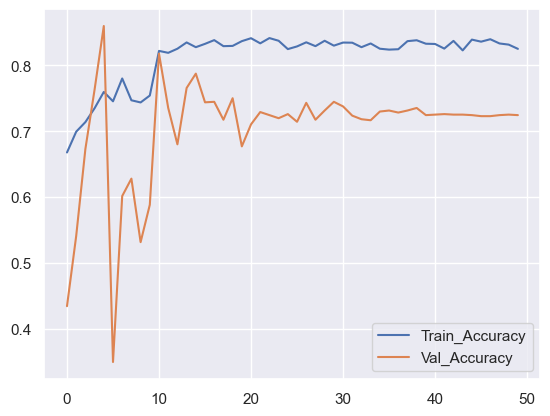

In [85]:
with open('kaggle_results/Shuffled_model_2_layers_lr0,1gamma0,1_step10_Metrics.txt','r') as f:
    d=f.read()
#Copy and paste the read file in d
d = json.loads(d)
epochs = len(d['Val_Accuracy'])
plt.plot(range(epochs),  d['Train_Accuracy'])
plt.plot(range(epochs),  d['Val_Accuracy'])
plt.legend(['Train_Accuracy', 'Val_Accuracy'])

In [41]:
def results(model, data_loader,*model_state_dicts):
    '''
    Plots the confusion matrix of the given model and state dictioanries
    
    Returns: Dictionary of Metrics of models with pprovided model_staate_dicts
    
    Arguments:
    
    model: Model of class torch.nn.Module
    
    data_loader: DataLoader of class torch.utils.data.DataLoader
    
    model_state_dicts: *args of Paths of stored state dictionaries of trained parameters
    '''
    sns.set()
    fig, ax = plt.subplots(len(model_state_dicts),1, figsize = (5, 5*len(model_state_dicts)))
    models_results = dict()
    device= ['cuda:0' if torch.cuda.is_available() == True else 'cpu']
    
    for index, state_dict in tqdm(enumerate(model_state_dicts), total=len(model_state_dicts)):

        model.load_state_dict(torch.load(state_dict))
        model.to(device[0])
        model.eval()
        torch.maual_seed(42)
        with torch.no_grad():
            preds = []
            labels = []
            for b,(X,y) in tqdm(enumerate(data_loader), total = len(data_loader)):
                pred = model(X.to(device[0]))
                loss =criterion(pred.cpu(), torch.tensor(y))
                preds.append(pred)
                labels.append(y)
        pred = [torch.argmax(i, axis =1).cpu() for i in preds]
        corr = 0
        for i in range(len(pred)):
            # print((pred[i].cpu() == labels[i]).numpy())
            corr+= np.sum((pred[i].cpu() == labels[i]).numpy())
        # print(corr/(len(pred)*10))
        # print(corr,len(labels)*10)
        preds_1d = []
        labels_1d =[]
        for i in pred:
            for j in i:
                preds_1d.append(j)
                        
        for i in labels:
            for j in i:
                labels_1d.append(j)
        cf_mat = torchmetrics.ConfusionMatrix(task= 'multiclass', num_classes =3)
        Acc = torchmetrics.Accuracy(task= 'multiclass', num_classes =3,average="macro",)
        Recall = torchmetrics.Recall(task= 'multiclass', num_classes =3,average="macro")
        F1 = torchmetrics.F1Score(task= 'multiclass', num_classes =3,average="macro")
        Precision = torchmetrics.Precision(task= 'multiclass', num_classes =3,average="macro")
        
        
        acc_score = Acc(torch.tensor((preds_1d)), torch.tensor(labels_1d))
        f1_score = F1(torch.tensor((preds_1d)), torch.tensor(labels_1d))
        precision_score =Precision(torch.tensor((preds_1d)), torch.tensor(labels_1d))
        recall_score = Recall(torch.tensor((preds_1d)), torch.tensor(labels_1d))
        cf=cf_mat(torch.tensor((preds_1d)), torch.tensor(labels_1d))
        state_dict = Path(state_dict).parts[-1]

        if len(model_state_dicts)==1:
            sns.heatmap(cf, annot = True)
            ax.set_title(state_dict)
            ax.set_xlabel('Prediction')
            ax.set_ylabel('Label')
        else:            
            sns.heatmap(cf, annot = True, ax= ax[index])
            ax[index].set_title(state_dict)
            ax[index].set_xlabel('Prediction')
            ax[index].set_ylabel('Label')
        # print(f'Acc:{acc_score}\nPrecision: {precision_score}\nRecall: {recall_score}\nF1_score: {f1_score}')
        models_results[state_dict] = {'Accuracy':acc_score, 'Precision':precision_score, 'Recall':recall_score, 'F1 Score': f1_score, 'Confusion_Matrix':cf}
    fig.tight_layout()
    return models_results

### Comparing models trained by chaning the number of layers. Models where trained with different last layers 2,4,5,6, and 8. Models with layers 4,5,6,8 where trained with a set lr of 0.001. THe best 2 models out of those were taken to train with a learningrate scheduler starting at 0.1.

D:\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/4 [00:00<?, ?it/s]

C:\Users\sesha\AppData\Local\Temp\ipykernel_14188\4133073094.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(state_dict))


  0%|          | 0/129 [00:00<?, ?it/s]

C:\Users\sesha\AppData\Local\Temp\ipykernel_14188\4133073094.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss =criterion(pred.cpu(), torch.tensor(y))
C:\Users\sesha\AppData\Local\Temp\ipykernel_14188\4133073094.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user 

  0%|          | 0/129 [00:00<?, ?it/s]

C:\Users\sesha\AppData\Local\Temp\ipykernel_14188\4133073094.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss =criterion(pred.cpu(), torch.tensor(y))
C:\Users\sesha\AppData\Local\Temp\ipykernel_14188\4133073094.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user 

  0%|          | 0/129 [00:00<?, ?it/s]

C:\Users\sesha\AppData\Local\Temp\ipykernel_14188\4133073094.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss =criterion(pred.cpu(), torch.tensor(y))
C:\Users\sesha\AppData\Local\Temp\ipykernel_14188\4133073094.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user 

  0%|          | 0/129 [00:00<?, ?it/s]

C:\Users\sesha\AppData\Local\Temp\ipykernel_14188\4133073094.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss =criterion(pred.cpu(), torch.tensor(y))


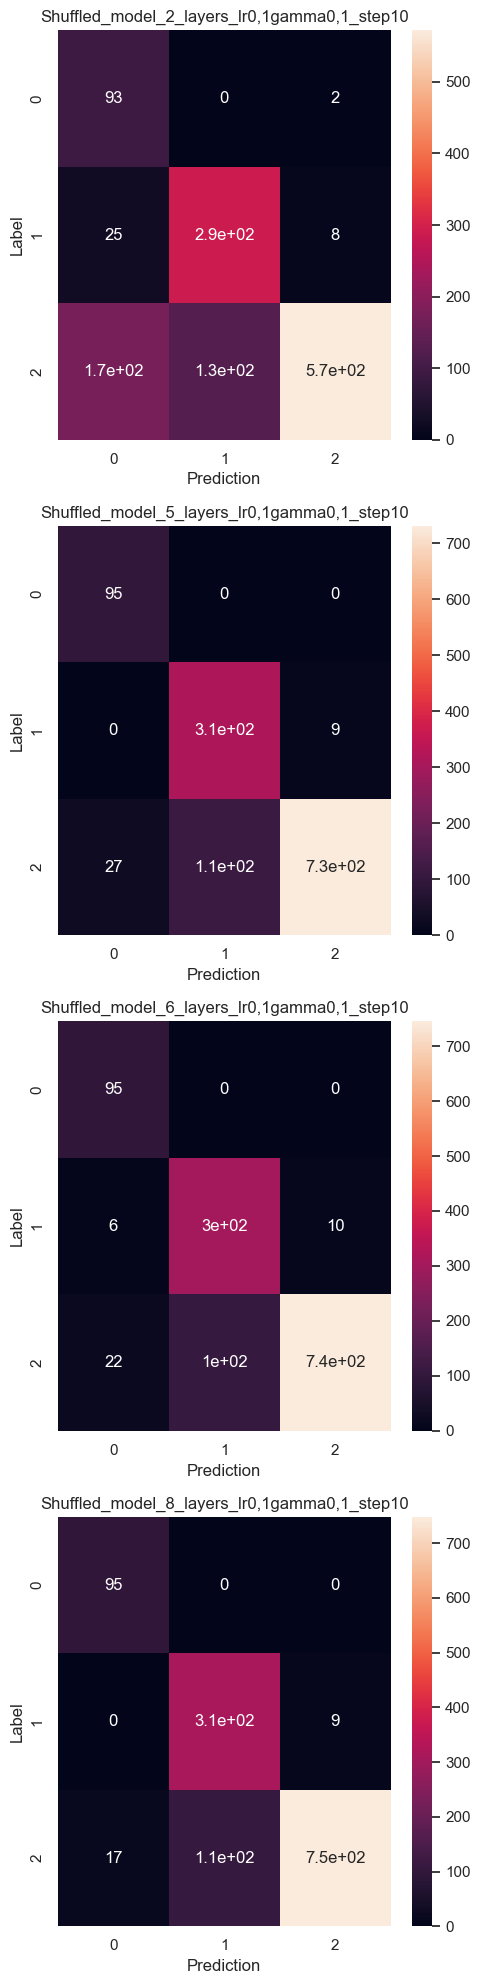

In [42]:
from pathlib import Path
model = ResNet(1,3)
res = results(model, val_loader,'kaggle_results/Shuffled_model_2_layers_lr0,1gamma0,1_step10',
             'kaggle_results/Shuffled_model_5_layers_lr0,1gamma0,1_step10','kaggle_results/Shuffled_model_6_layers_lr0,1gamma0,1_step10',
             'kaggle_results/Shuffled_model_8_layers_lr0,1gamma0,1_step10')
# ,
#               'Shuffled_model_4_layers','Shuffled_model_5_layers', 'Shuffled_model_6_layers','Shuffled_model_8_layers',
#               'Shuffled_model_5_layers_lr0,1gamma0,1_step10(1)','Shuffled_model_6_layers_lr0,1gamma0,1_step10')

In [43]:
res

{'Shuffled_model_2_layers_lr0,1gamma0,1_step10': {'Accuracy': tensor(0.8440),
  'Precision': tensor(0.6655),
  'Recall': tensor(0.8440),
  'F1 Score': tensor(0.6838),
  'Confusion_Matrix': tensor([[ 93,   0,   2],
          [ 25, 288,   8],
          [173, 127, 572]])},
 'Shuffled_model_5_layers_lr0,1gamma0,1_step10': {'Accuracy': tensor(0.9368),
  'Precision': tensor(0.8330),
  'Recall': tensor(0.9368),
  'F1 Score': tensor(0.8726),
  'Confusion_Matrix': tensor([[ 95,   0,   0],
          [  0, 312,   9],
          [ 27, 114, 731]])},
 'Shuffled_model_6_layers_lr0,1gamma0,1_step10': {'Accuracy': tensor(0.9348),
  'Precision': tensor(0.8343),
  'Recall': tensor(0.9348),
  'F1 Score': tensor(0.8739),
  'Confusion_Matrix': tensor([[ 95,   0,   0],
          [  6, 305,  10],
          [ 22, 105, 745]])},
 'Shuffled_model_8_layers_lr0,1gamma0,1_step10': {'Accuracy': tensor(0.9433),
  'Precision': tensor(0.8603),
  'Recall': tensor(0.9433),
  'F1 Score': tensor(0.8932),
  'Confusion_Matrix'

### From the metrics all show that the models trained over the last 5,6 and 8 layers all perform similarly

In [44]:
df = pd.DataFrame(res)
df

,"Shuffled_model_2_layers_lr0,1gamma0,1_step10","Shuffled_model_5_layers_lr0,1gamma0,1_step10","Shuffled_model_6_layers_lr0,1gamma0,1_step10","Shuffled_model_8_layers_lr0,1gamma0,1_step10"
Accuracy,tensor(0.8440),tensor(0.9368),tensor(0.9348),tensor(0.9433)
Precision,tensor(0.6655),tensor(0.8330),tensor(0.8343),tensor(0.8603)
Recall,tensor(0.8440),tensor(0.9368),tensor(0.9348),tensor(0.9433)
F1 Score,tensor(0.6838),tensor(0.8726),tensor(0.8739),tensor(0.8932)
Confusion_Matrix,"[[tensor(93), tensor(0), tensor(2)], [tensor(2...","[[tensor(95), tensor(0), tensor(0)], [tensor(0...","[[tensor(95), tensor(0), tensor(0)], [tensor(6...","[[tensor(95), tensor(0), tensor(0)], [tensor(0..."


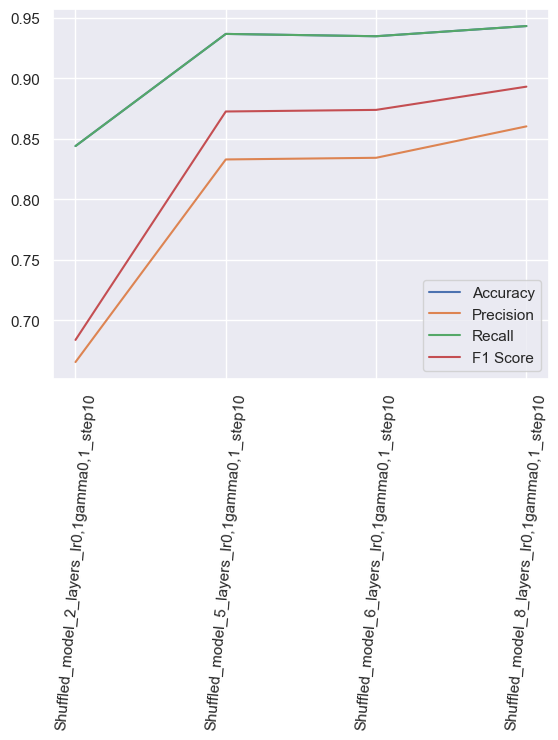

In [46]:
fig = plt.figure()
rows = df.index
row_index = 0
for i in range(2):
    for j in range(2):

        plt.plot(df.columns,df.loc[rows[row_index]])
        plt.xticks(rotation=85)
        row_index+=1
plt.legend(df.index)        
plt.show()
fig.tight_layout()


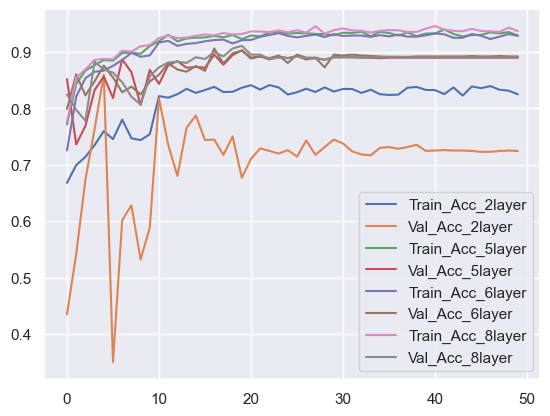

In [86]:
models = ['kaggle_results/Shuffled_model_2_layers_lr0,1gamma0,1_step10_Metrics.txt',
             'kaggle_results/Shuffled_model_5_layers_lr0,1gamma0,1_step10_Metrics.txt',
              'kaggle_results/Shuffled_model_6_layers_lr0,1gamma0,1_step10_Metrics.txt',
             'kaggle_results/Shuffled_model_8_layers_lr0,1gamma0,1_step10_Metrics.txt']
for path in models:
    with open(path,'r') as f:
        d=f.read()
    #Copy and paste the read file in d
    d = json.loads(d)
    epochs = len(d['Val_Accuracy'])
    plt.plot(range(epochs),  d['Train_Accuracy'])
    plt.plot(range(epochs),  d['Val_Accuracy'])
plt.legend(['Train_Acc_2layer','Val_Acc_2layer','Train_Acc_5layer','Val_Acc_5layer','Train_Acc_6layer','Val_Acc_6layer',
            'Train_Acc_8layer','Val_Acc_8layer'])